This project is aimed at predicting house price in the test dataset with creative feature engineering and advanced regression techniques such as gradient boosting. The data can be found on Kaggle dataset, House Price - Advanced Regression Techniques. Using 79 features describing (almost) every aspect of residential homes in Ames, Iowa, this project predicts the final price of each home. This project is created with ideas from the awesome Kaggle tutorial of  Feature Engineering by Ryan Holbrook and Alexis Cook.

Main steps of this project:
1. data preprocessing (clean errors and inconsistency, deal with missing values, encode data types, load the data)
2. feature utility metrics to identify the features that have strong association with the target, drop features with low correlation
3. create features
4. hyperparameters
5. train the models

In [1]:
import os
import warnings
from pathlib import Path

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display
from pandas.api.types import CategoricalDtype

from sklearn.model_selection import train_test_split
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

In [2]:
# # first look of the dataset

# df_train = pd.read_csv('house_train.csv', index_col="Id")
# df_test = pd.read_csv('house_test.csv', index_col="Id")
# df_train.columns
# df_train.shape
# df_train.head()
# df_train.isnull().sum()
# df_train.describe()
# df_test.info()

Step 1: data preprocessing
- clean data (error, inconsistency)
- encode data type
- deal with missing values if any
- load the data and split into training and test set

In [3]:
def load_data():
    # Read data
    df_train = pd.read_csv('house_train.csv', index_col="Id")
    df_test = pd.read_csv('house_test.csv', index_col="Id")

    # merge train and test data
#     df = pd.concat([df_train, df_test])   
    
    # preprocessing
    for df in [df_train, df_test]:
        df = clean(df)
        df = encode(df)
        df = impute_missing_values(df)
    
    # split to train and test data
#     df_train = df.loc[df_train.index, :]
#     df_test = df.loc[df_test.index, :]    
         
    return df_train, df_test

In [4]:
# data clean
# check all the unique values of each categorical feature and correct with data description

def clean(df):

    # In MSzoning, change 'C (all)' to C
    df['MSZoning'] = df['MSZoning'].replace({'C (all)':'C'})

    # df_full column 'Exterior2nd' replace 'Wd Shng' with 'WdShing', replace 'Brk Cmn' with 'BrkComm'
    df['Exterior2nd'] = df['Exterior2nd'].replace({'Wd Shng':'WdShing', 'Brk Cmn':'BrkComm'})

    # replace columns names with better ones
    df.rename(columns={
            "1stFlrSF": "FirstFlrSF",
            "2ndFlrSF": "SecondFlrSF",
            "3SsnPorch": "Threeseasonporch"}, inplace=True)

    # some value of GarageYrBlt is even smaller than YearBuilt, we replace such value of GarageYrBlt with YearBuilt
    df['GarageYrBlt'] = df['GarageYrBlt'].where(df.GarageYrBlt < df.YearBuilt, df.YearBuilt)
    
    return df



Encode data type

Categorical features: 
- ordinal: OverallQual, OverallCond, LotShape, Utilities, ExterQual, ExterCond, HeatingQC, KitchenQual, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, Functional, PavedDrive
- nominal: MSSubClass, MSZoning, Street, Alley, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, MiscFeature, SaleType, SaleCondition

Numerical features: 
- discrete: SalePrice, LotArea, YearBuilt, YearRemodAdd, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, Bedroom, Kitchen, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, PoolArea, MiscVal, MoSold, YrSold, 
- continuous: LotFrontage, MasVnrArea, GarageYrBlt

Missing values

Ordinal featuers that need to add a 'None' value and change na to 'None':
- Utilities, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, PoolQC, Fence, GarageFinish, GarageQual, GarageCond 

Nominal featuers that need to add a 'None' value and change na to 'None':
- Alley, Exterior1st, Exterior2nd, Electrical, Functional, FireplaceQu, MiscFeature, GarageType, MasVnrType

Numerical featuers that need to replace na with 0:
- LotFrontage, MasVnrArea, BsmtFinSF1, BsmtFinSF2, TotalBsmtSF, BsmtFullBath, BsmtHalfBath, GarageCars, GarageArea, GarageYrBlt


In [5]:
# nominal featuers
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

# ordinal features
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "PavedDrive": ["N", "P", "Y"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],    
    "PoolQC": five_levels,
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "GarageQual": five_levels,
    "GarageCond": five_levels
}

ordered_levels = {key: ['None'] + value for key, value in ordered_levels.items()}




In [6]:
# encode data type and create None category for missing values

def encode(df):
#   nominal features
    for feature in features_nom:
        df[feature] = df[feature].astype('category')
        if 'None' not in df[feature].cat.categories: # and df[feature].isnull().sum()>0:
            df[feature].cat.add_categories('None',inplace=True)

#   ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered=True))
    
    return df

Missing values
- replace categorical missing values with 'None'
- replace numerical missing values with 0

In [7]:
def impute_missing_values(df):
    for name in df.select_dtypes('category'):
        df[name] = df[name].fillna('None')
    
    l = df.select_dtypes('number').columns.tolist()
    l.pop()
    for name in l:
        df[name] = df[name].fillna(0)
    return df


In [8]:
# load the data
# since we replace missing values with 'None' or 0, we can replace the full dataset
# if we are using other imputation methods, we may need to impute train and test dataset separately to avoid data leakage

df_train, df_test = load_data()

In [9]:
df_train.shape, df_test.shape

((1460, 80), (1459, 79))

In [10]:
# Establish a baseline

# using RMSLE as score to evaluate models
# the basline is based on gradient boosting model with only encoding categorical featuers

def score_model(X, y, model=XGBRegressor()):
    try:
        for col in X.select_dtypes(['category']):
            X[col] = X[col].cat.codes
        log_y = np.log(y)
        score = cross_val_score(model, X, log_y, cv=5, scoring='neg_mean_absolute_error')
        score = -1 * score.mean()
        score = np.sqrt(score)
        return score
    
    except Exception as e:
            print('Error occured '+str(e))

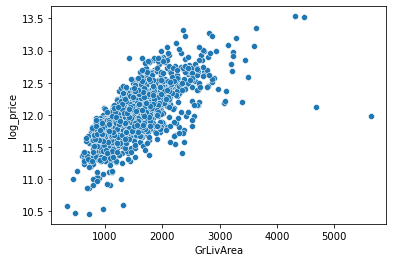

In [11]:
X = df_train.copy()
X['log_price'] = np.log1p(X['SalePrice'])
sns.scatterplot(data=X, y='log_price', x='GrLivArea');

In [12]:
X = df_train.copy()
y = X.pop('SalePrice')
baseline_score = score_model(X,y)
print(f'Baseline score: {baseline_score:.5f} RMSLE')

Baseline score: 0.31105 RMSLE


2. Feature Utility Scores
- We are using a utility score to select the features that are highly related to our target (SalesPrice) and drop the features that have zero correlation with the target. There is limitation in this method as the utility score is based on linear relationship and we may get into trouble of accidentally dropping the features that have low linear correlation with the target but strong nonlinear relationship.

In [13]:
def make_mi_scores(X,y):
    try:
        X = X.copy()

        # label encoding categorical features and treat them as discrete
        for colname in X.select_dtypes(['category','object']):
            X[colname], _ = X[colname].factorize()

        # all discrete features should have integer dtype
        discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]

        # calcuate MI scores for all features, arrange and sort
        mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features, random_state=0)
        mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)

        return mi_scores

    except Exception as e:
            print('Error occured '+str(e))

In [15]:
pd.set_option('display.max_rows', None)

In [16]:
X = df_train.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual         5.786503e-01
Neighborhood        5.253900e-01
GarageArea          4.927946e-01
GrLivArea           4.328080e-01
YearBuilt           4.087151e-01
TotalBsmtSF         3.995179e-01
LotArea             3.924269e-01
GarageYrBlt         3.631249e-01
GarageCars          3.601015e-01
BsmtQual            3.313983e-01
ExterQual           3.251496e-01
KitchenQual         3.224720e-01
FirstFlrSF          2.832649e-01
MSSubClass          2.781834e-01
YearRemodAdd        2.756588e-01
FullBath            2.731560e-01
GarageFinish        2.629453e-01
LotFrontage         2.160922e-01
FireplaceQu         2.093477e-01
TotRmsAbvGrd        2.079625e-01
GarageType          2.019024e-01
Foundation          1.929394e-01
OpenPorchSF         1.890468e-01
HeatingQC           1.735858e-01
Fireplaces          1.702530e-01
SecondFlrSF         1.678137e-01
BsmtFinSF1          1.566927e-01
BsmtFinType1        1.566483e-01
Exterior2nd         1.550760e-01
BsmtUnfSF           1.273479e-01
Exterior1s

In [17]:
def drop_uninformative(df, mi_scores):
    try:
        return df.loc[:,mi_scores > 0.00036]
    except Exception as e:
        print('Error occured: '+str(e))

In [18]:
X = df_train.copy()
y = X.pop('SalePrice')
X = drop_uninformative(X, mi_scores)

score_model(X,y)
# Lower values of RMSE indicate better fit after dropping some features

0.30949027514597593

3. Create features
There are a few steps to create features. 
- step 1: label encoding for categorical features: 
    - for every categorical feature, it will assign a number to each category
    - it works for tree-ensemble methods
    - but better use one-hot encoding if using linera regression, especially for features with unordered categories (this will generate a dummy variable for each category of every categorical feature)
    
- step 2: create features with Pandas using mathemmatical transformation
- step 3: K-means clustering (unsupervised)
    - we pick the features to be used for clustering, rescale the features if they are not already comparable, and generate a "cluster" category for each sample
- step 4: PCA (unsupervised)
    - we use PCA to find potential relationships in the data
    - it doesn't create any new features on its own, but it suggests features
    - apply pca, add new features, spot outliers
- (potential) step 5: target encoding

In [19]:
# 3. Create features
# step 1: label encoding for categorical features

# def label_encoding(df):
#     try:
#         X = df.copy()
#         for col in X.select_dtypes(['category']):
#             X[col] = X[col].cat.codes
#         return X
#     except Exception as e:
#         print("Error occurred: "+str(e))

In [20]:
def label_encoding_new(df):
    try:
        X = df.copy()
        for col in X.select_dtypes(['category']):
            X[col] = X[col].astype('str')
        X = X.apply(LabelEncoder().fit_transform)
        
        return X
    except Exception as e:
        print("Error occurred: "+str(e))

In [21]:
# 3. Create features
# step 2: create features with Pandas using mathemmatical transformation

def math_new_features(df):
    try:
        X = pd.DataFrame()
        X['LivLotRatio'] = df.GrLivArea / df.LotArea
        X['Spaciousness'] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
        X['TotalOutdoorSF'] = df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + df.Threeseasonporch + df.ScreenPorch
        return X
    
    except Exception as e:
        print("Error occurred: "+str(e))

In [22]:
def add_interactions(df):
    try:
        X = pd.DataFrame()
        X = pd.get_dummies(df.BldgType, prefix='Bldg')
        X = X.mul(df.GrLivArea, axis=0)
        
        # create interactions between OverallQual and OverallCond
#         X['Qual'] = int(df.OverallQual)
#         X['Cond'] = int(df.OverallCond)
#         X['QualCond'] = X['Qual'].mul(X.Cond, axis=0)
        return X
    
    except Exception as e:
        print("Error occurred: "+str(e))

In [23]:
def counts(df):
    # add how many types of porch the property has
    # gt(0.0) the value is greater than 0
    try:
        X = pd.DataFrame()
        X["PorchTypes"] = df[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "Threeseasonporch", "ScreenPorch"]].gt(0.0).sum(axis=1)
        return X
    
    except Exception as e:
        print("Error occurred: "+str(e))

In [24]:
def group_transform(df):
    try:
        X = pd.DataFrame()
        X['MedNbArea'] = df.groupby('Neighborhood')['GrLivArea'].transform("median")
        X['CntNbArea'] = df.groupby('Neighborhood')['GrLivArea'].transform("count")
        return X
    except Exception as e:
        print("Error occurred: "+str())

In [25]:
# 3. Create features
# step 3: K-means clustering (unsupervised)

cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea"
]

def cluster_labels(df, cluster_features, n_clusters=10):
    try:
        X = df.copy()
        X_scaled = X.loc[:, cluster_features]
        X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
        
        kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
        X_new = pd.DataFrame()
        X_new['Cluster'] = kmeans.fit_predict(X_scaled)
        X_new['Cluster'] = X_new['Cluster'].astype('category')
        
        return X_new
    except Exception as e:
        print("Error Occurred: "+str(e))

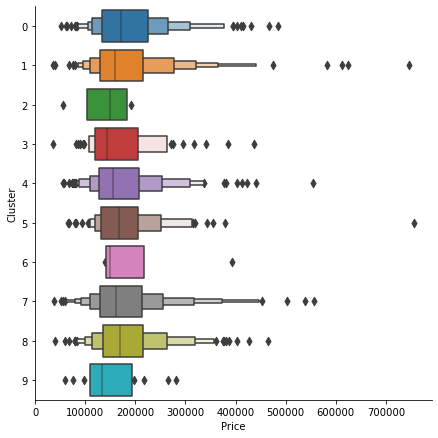

In [26]:
# visualise the house price distribution of each cluster
X_new = cluster_labels(df_train, cluster_features)
X_new['Price'] = df_train['SalePrice']

sns.catplot(x="Price", y="Cluster", data=X_new, kind="boxen", height=6);

In [27]:
# 3. Create features
# step 4: PCA (unsupervised) only works for numeric features

def apply_pca(X, standardize=True):
    try:
        # Standardize
        if standardize:
            X = (X - X.mean(axis=0)) / X.std(axis=0)
        # Create principal components
        pca = PCA()
        X_pca = pca.fit_transform(X)
        # Convert to dataframe
        component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
        X_pca = pd.DataFrame(X_pca, columns=component_names)
        # Create loadings
        # (tells us in each component, which features vary in the same direction)
        # the negative loading may tell us the meaning of the component or how we call the component

        loadings = pd.DataFrame(
            pca.components_.T,  # transpose the matrix of loadings
            columns=component_names,  # so the columns are the principal components
            index=X.columns,  # and the rows are the original features
        )
        return pca, X_pca, loadings
    
    except Exception as e:
        print("Error Occurred: "+str(e)) 

In [29]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    try:
        # Create figure
        fig, axs = plt.subplots(1, 2)
        n = pca.n_components_
        grid = np.arange(1, n + 1)
        # Explained variance
        evr = pca.explained_variance_ratio_
        axs[0].bar(grid, evr)
        axs[0].set(
            xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
        )
        # Cumulative Variance
        cv = np.cumsum(evr)
        axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
        axs[1].set(
            xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
        )
        # Set up figure
        fig.set(figwidth=8, dpi=100)
        return axs
    except Exception as e:
        print("Error Occurred: "+str(e))

def make_mi_scores_pca(X, y, discrete_features):
    try:
        mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
        return mi_scores
    except Exception as e:
        print("Error Occurred: "+str(e)) 


In [30]:
# select the numeric features for PCA
features = ['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'TotalBsmtSF',
 'FirstFlrSF',
 'SecondFlrSF',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'GarageArea']

print("Correlation with SalePrice:\n")
print(df_train[features].corrwith(df_train.SalePrice))

Correlation with SalePrice:

LotFrontage     0.209624
LotArea         0.263843
MasVnrArea      0.472614
TotalBsmtSF     0.613581
FirstFlrSF      0.605852
SecondFlrSF     0.319334
GrLivArea       0.708624
FullBath        0.560664
HalfBath        0.284108
BedroomAbvGr    0.168213
TotRmsAbvGrd    0.533723
GarageArea      0.623431
dtype: float64


In [31]:
# select the numeric features for PCA
X = df_train.copy()
y = X.pop("SalePrice")
X = X.loc[:, features]

pca, X_pca, loadings = apply_pca(X)
print(loadings)

                   PC1       PC2       PC3       PC4       PC5       PC6  \
LotFrontage   0.147963  0.135361  0.360384 -0.644161  0.610672 -0.044321   
LotArea       0.154878  0.152481  0.256209  0.749756  0.501724 -0.021630   
MasVnrArea    0.238551  0.118552 -0.506817 -0.081393  0.090152  0.700554   
TotalBsmtSF   0.268571  0.452262 -0.053387  0.012997 -0.057340  0.044454   
FirstFlrSF    0.297046  0.448626  0.075987  0.041578 -0.145044  0.058452   
SecondFlrSF   0.270314 -0.493672 -0.076361  0.016393  0.082032 -0.109168   
GrLivArea     0.445427 -0.084930  0.006120  0.042490 -0.040381 -0.045072   
FullBath      0.335859 -0.023369  0.026757 -0.039448 -0.394623 -0.333761   
HalfBath      0.185667 -0.367147 -0.425135  0.050811  0.362826 -0.089874   
BedroomAbvGr  0.271799 -0.273691  0.442928 -0.010424 -0.167502  0.348950   
TotRmsAbvGrd  0.402861 -0.169220  0.206666 -0.022410 -0.115247  0.090929   
GarageArea    0.286227  0.220809 -0.335816 -0.087046  0.076360 -0.487793   

           

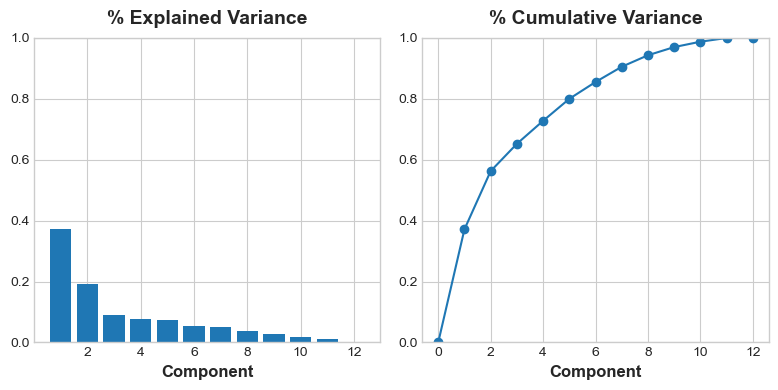

In [32]:
plot_variance(pca);

In [33]:
# identify the most useful PCs
X = df_train.copy()
y = X.pop('SalePrice')
mi_scores = make_mi_scores_pca(X_pca, y, discrete_features=False)
mi_scores

PC1     0.563381
PC2     0.346878
PC9     0.145482
PC4     0.104353
PC3     0.104300
PC8     0.089958
PC6     0.080677
PC5     0.063555
PC12    0.050965
PC7     0.040403
PC10    0.022606
PC11    0.021178
Name: MI Scores, dtype: float64

In [34]:
# bedroom/bathroom number ratio; secondFlrSF/FirstFlrSF
# create new features

def pca_features(df):
    try:
        X = pd.DataFrame()
        X['BdBrRatio'] = df['BedroomAbvGr'] / (df['FullBath'] + df['HalfBath'] + 1)
        X['BowlShapeness'] = df['SecondFlrSF'] / df['FirstFlrSF']
        X['TotalArea'] = df['GrLivArea'] +df['TotalBsmtSF'] +df['GarageArea']
        return X
    
    except Exception as e:
        print('Error occurred: '+str(e))

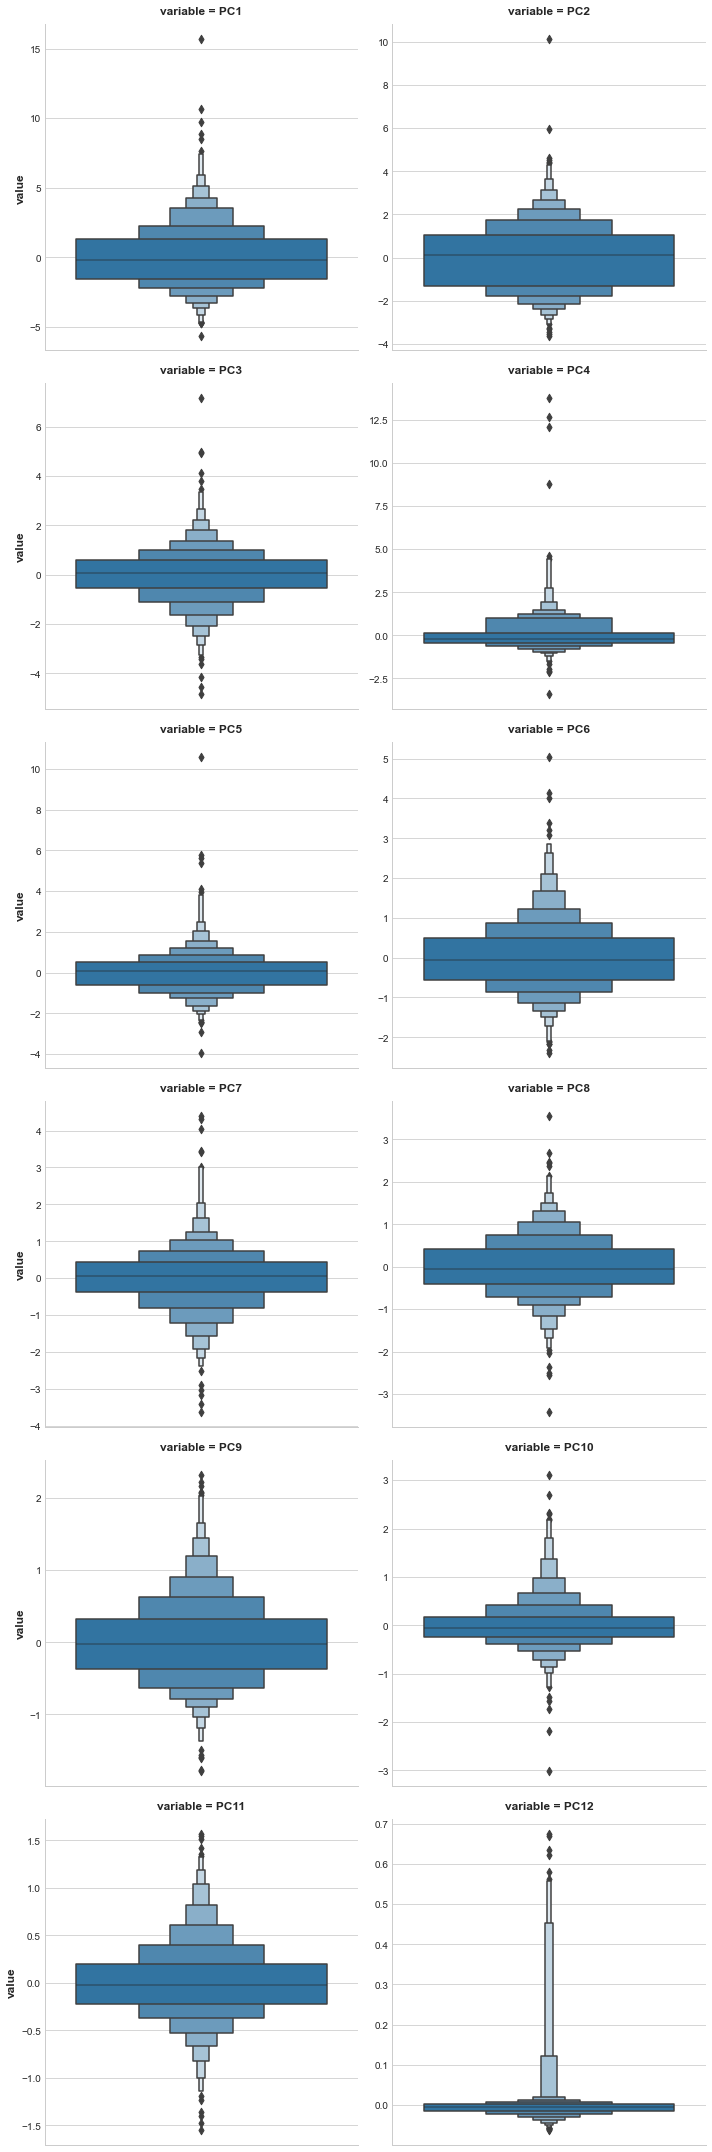

In [35]:
# spot outliers

sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [36]:
# # indicate the outliers
# component = "PC1"

# idx = X_pca[component].sort_values(ascending=False).index
# X.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"]+ features]

# def indicate_outliers(df):
#     X_new = pd.DataFrame()
#     X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
#     return X_new

3. Create features
- potential step 5: target encoding (supervised)
    - encode a feature (such as MSSubClass) with the mean of the target (SalePrice)
    - split the data for cross validation so that no data is wasted

In [37]:
# 3. Create features
# combine create features functions

def create_features(df_train, df_test=None):
    try:
        X = df_train.copy()
        y = X.pop('SalePrice')     
        mi_scores = make_mi_scores(X,y)
        
        if df_test is not None:
            X_test = df_test.copy()
            X = pd.concat([X, X_test])
        
        X = drop_uninformative(X, mi_scores) 
        X = X.join(math_new_features(X))
        X = X.join(add_interactions(X))
        X = X.join(counts(X))
        
        if df_test is not None:
            X_test = X.loc[df_test.index, :]
            X.drop(df_test.index, inplace=True)
            X_test = X_test.join(group_transform(X_test))
            X_test = X_test.join(cluster_labels(X_test, cluster_features, n_clusters=15))
            X_test = X_test.join(pca_features(X_test))
            X_test = label_encoding_new(X_test)
            
        X = X.join(group_transform(X))
        X = X.join(cluster_labels(X, cluster_features, n_clusters=15))
        X = X.join(pca_features(X))        
        X = label_encoding_new(X)
        
        if df_test is not None:
            return X, X_test
        else:
            return X
    
    except Exception as e:
        print("Error occurred: "+str(e))

In [38]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

cleaned_scores = score_model(X_train,y_train)
print(f"After data cleaning score: {cleaned_scores:.5f} RMSLE. \nBaseline score is {baseline_score:.5f} RMSLE")

After data cleaning score: 0.30970 RMSLE. 
Baseline score is 0.31105 RMSLE


4. Hyperparameter Tuning with XGBoost parameters
- parameters that need to consider include: n_estimators, early_stopping_rounds, learning_rate, n_jobs

In [39]:
# 4. hyperparameter
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=5,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.02,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1)   # set > 1 for boosted random forests

xgb = XGBRegressor(**xgb_params)
score_model(X_train, y_train, xgb)

0.28345972157486554

5. Train model
- train the training data with XGBoost
- make predictions from the test dataset

In [40]:
# 5. train the models

X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train, np.log(y_train))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id':X_test.index, 'EstSalePrice':predictions})
output.to_csv('house_price_submission.csv', index=False)